## Personal Key Indicators of Heart Disease, an analysis

Heart disease is a leading cause of death in countries around the world. 

Research shows a number of comorbidities contribute to the risk of developing disease at all ages. 

Being able to predict the prevalence of heart disease will allow us to identify patients sooner and continue evolving from reactive medicine towards proactive intervention.

*Using this dataset, how accurately can we predict the prevalence of heart disease?*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import os

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from dython.nominal import associations, numerical_encoding, cluster_correlations
from dython.data_utils import split_hist

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, classification_report
from xgboost import XGBClassifier

from sklearn_evaluation import plot, table


/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sns.set_theme(style='whitegrid', palette='pastel')

In [3]:
data = pd.read_csv('../Capstone-Two/heartPHI2020.csv')
df = data.copy()

In [4]:
df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Dataset and column descriptions:

Kaggle Dataset at https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Adapted by the creator from the 2020 annual CDC BRFSS survey data of 400k adults related to their health status to include heart disease indicators. 

**Column Details:**

*HeartDisease:* Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI). *(Yes / No)*

*BMI:* Body Mass Index (BMI) *(BMI=kg/(m^2))*

*Smoking:* Have you smoked at least 100 ciagrettes in your entire life? [Note: 1 pack = ~25 cigarettes] *(Yes / No)*

*AlcoholDrinking:* Heavy drinker? (Adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) *(Yes / No)*

*Stroke:* Have you ever been told you had a stroke? *(Yes / No)*

*PhysicalHealth:* How many days during the past 30 days was your physical health not good? (Including physical illness or injury.) *(0-30 days)*

*MentalHealth:* How many days during the past 30 days was your mental health not good? (Includes stress, depression, and problems with emotions.) *(0-30 days)*

*DiffWalking:* Do you have serious difficulty walking or climbing stairs? *(Yes / No)*

*Sex:* Are you Female or Male? *('Male', 'Female')*

*AgeCategory:* thirteen age categories. *('18-24', '25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80 or older')*

*Race:* Which one of these groups best represents your race? *('White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Hispanic', 'Other')*

*Diabetic:* Have you ever been told you have diabetes? *('Yes','No'','No, borderline diabetes', 'Yes (during pregnancy)')*

*PhysicalActivity:* Respondents who reported doing physical activity or exercise during the past 30 days other than their regular job. *(Yes / No)*

*GenHealth:* Would you say that your general health is- *('Poor','Fair','Good','Very good','Excellent')*

*SleepTime:* On average, how many hours of sleep do you get in a 24-hour period? *(0-24)*

*Asthma:* Have you ever been told you had asthma? *(Yes / No)*

*KidneyDisease:* Were you ever told you have kidney disease (Not including kidney stones, bladder infection or incontinence.) *(Yes / No)*

*SkinCancer:* Were you ever told you had skin cancer? *(Yes / No)*

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [6]:
df.describe(include='all')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795,319795.000000,319795,319795,319795,319795.00000,319795.000000,319795,319795,319795,319795,319795,319795,319795,319795.000000,319795,319795,319795
unique,2,NaN,2,2,2,NaN,NaN,2,2,13,6,4,2,5,NaN,2,2,2
top,No,NaN,No,No,No,NaN,NaN,No,Female,65-69,White,No,Yes,Very good,NaN,No,No,No
freq,292422,NaN,187887,298018,307726,NaN,NaN,275385,167805,34151,245212,269653,247957,113858,NaN,276923,308016,289976
mean,NaN,28.325399,NaN,NaN,NaN,3.37171,3.898366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097075,NaN,NaN,NaN
std,NaN,6.356100,NaN,NaN,NaN,7.95085,7.955235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436007,NaN,NaN,NaN
min,NaN,12.020000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,24.030000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
50%,NaN,27.340000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN
75%,NaN,31.420000,NaN,NaN,NaN,2.00000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN


In [7]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

## EDA and Data Wrangling

In [8]:
nunique = df.nunique().sort_values()
print('Number of Unique Values by Column' + '\n')
nunique

Number of Unique Values by Column



HeartDisease           2
Asthma                 2
PhysicalActivity       2
KidneyDisease          2
DiffWalking            2
Sex                    2
Stroke                 2
AlcoholDrinking        2
Smoking                2
SkinCancer             2
Diabetic               4
GenHealth              5
Race                   6
AgeCategory           13
SleepTime             24
MentalHealth          31
PhysicalHealth        31
BMI                 3604
dtype: int64

In [9]:
# unique values in column
columns = df.columns
print('List of Unique Values by Column' + '\n' + '\n')
for col in columns:
    print(f'{col}:  {str(df[col].unique())} \n')

List of Unique Values by Column


HeartDisease:  ['No' 'Yes'] 

BMI:  [16.6  20.34 26.58 ... 62.42 51.46 46.56] 

Smoking:  ['Yes' 'No'] 

AlcoholDrinking:  ['No' 'Yes'] 

Stroke:  ['No' 'Yes'] 

PhysicalHealth:  [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 

MentalHealth:  [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.] 

DiffWalking:  ['No' 'Yes'] 

Sex:  ['Female' 'Male'] 

AgeCategory:  ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29'] 

Race:  ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic'] 

Diabetic:  ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] 

PhysicalActivity:  ['Yes' 'No'] 

GenHealth:  ['Very good' 'Fair' 'Good' 'Poor' 'Excellent'] 

SleepTime:  [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 1

In [10]:
# people with MentalHealth or PhysicalHealth response of 0, 
# responded that they had mental and physical problems 0 out of the last 30 days
df[['SleepTime', 'PhysicalHealth', 'MentalHealth']] = df[['SleepTime', 'PhysicalHealth', 'MentalHealth']].astype(int)

In [11]:
# similar to this study - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877313/
# will evaluate, BMI PhysicalHealth, MentalHealth, and SleepTime as both continuous and categorical variables
# they used these bins for SleepTime of ≤ 6 h, > 6 to < 9 h, ≥ 9 h
# MentalHealth and PhysicalHealth variables are responses to how many days in last 30-31 were bad for health
# binning them by week
# Underweight: Less than 18.5, Healthy: 18.5 to 24.9, Overweight: 25 to 29.9, Class I obesity: 30 to 34.9, Class II obesity: 35 to 39.9, Class III obesity: More than 40.

sleep_bins = [-np.inf, 5, 7, 9, np.inf]
sleep_labels = ['≤ 5', '> 5 to ≤ 7 h', '> 7 to ≤ 9 h', '> 9 h']
df['SleepTime_binned'] = pd.cut(df['SleepTime'], bins=sleep_bins, labels=sleep_labels)

bmi_bins = [-np.inf, 18.49, 24.9, 29.9, 34.9, 39.9, np.inf]
bmi_labels = ['Underweight','Healthy','Overweight', 'Class I Obesity', 'Class II Obesity', 'Class III Obesity']
df['BMI_binned'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

mental_bins = [-np.inf, 7, 14, 21, np.inf]
mental_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['MentalHealth_binned'] = pd.cut(df['MentalHealth'], bins=mental_bins, labels=mental_labels)

physical_bins = [-np.inf, 7, 14, 21, np.inf]
physical_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['PhysicalHealth_binned'] = pd.cut(df['PhysicalHealth'], bins=physical_bins, labels=physical_labels)

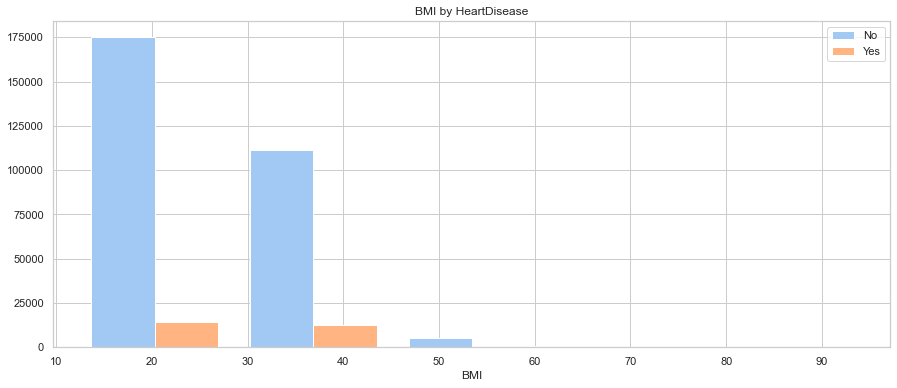

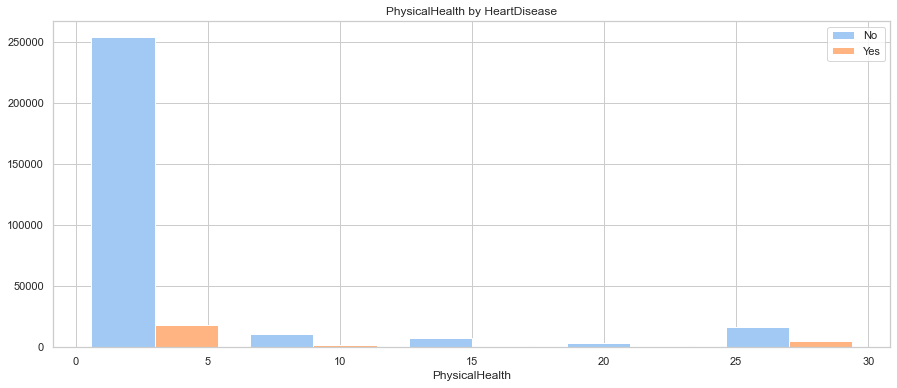

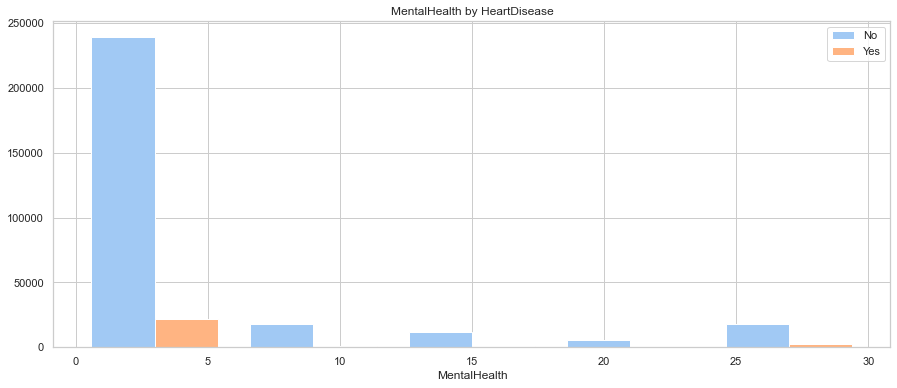

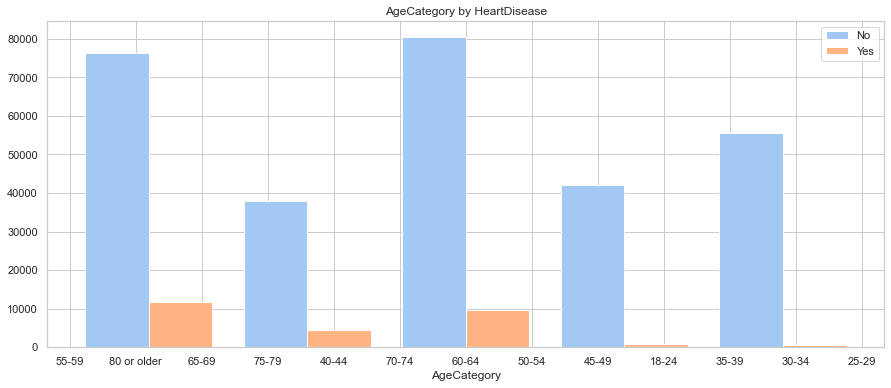

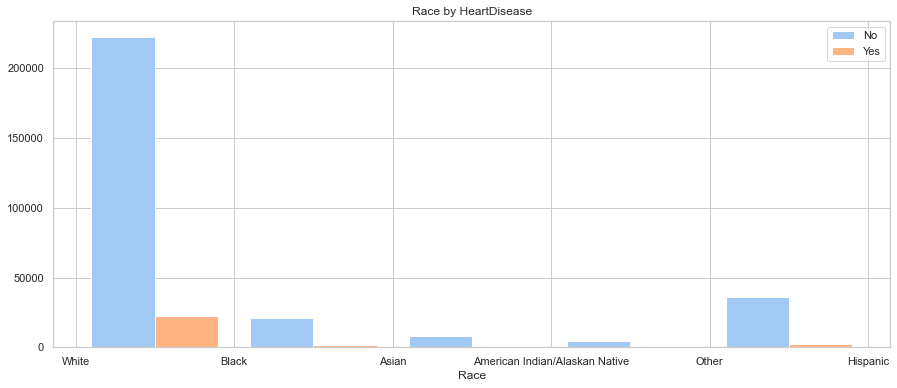

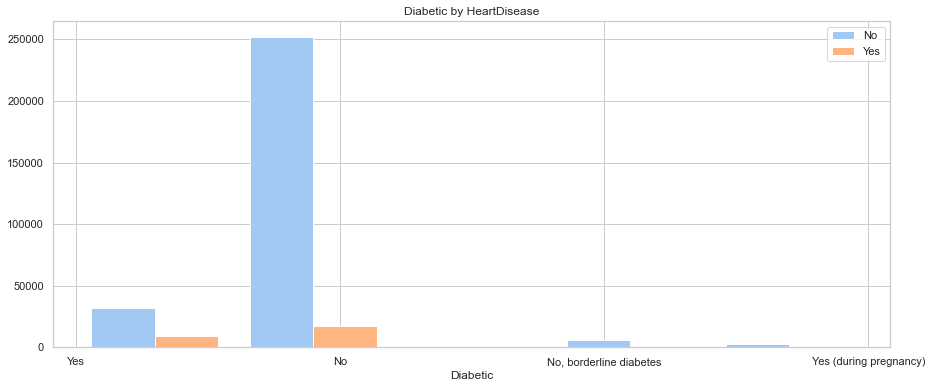

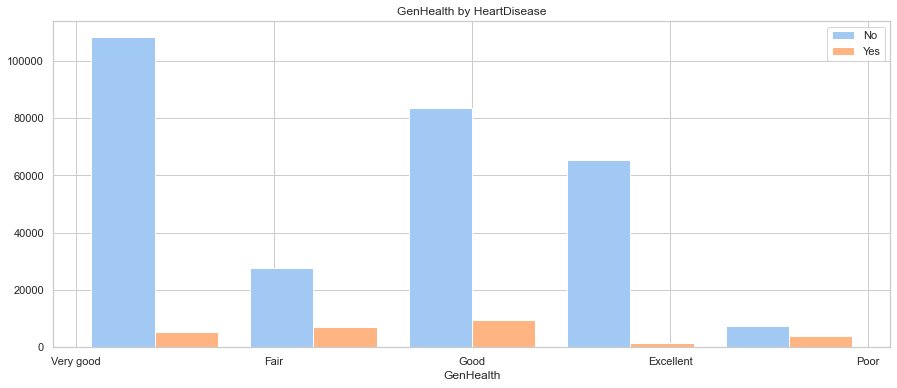

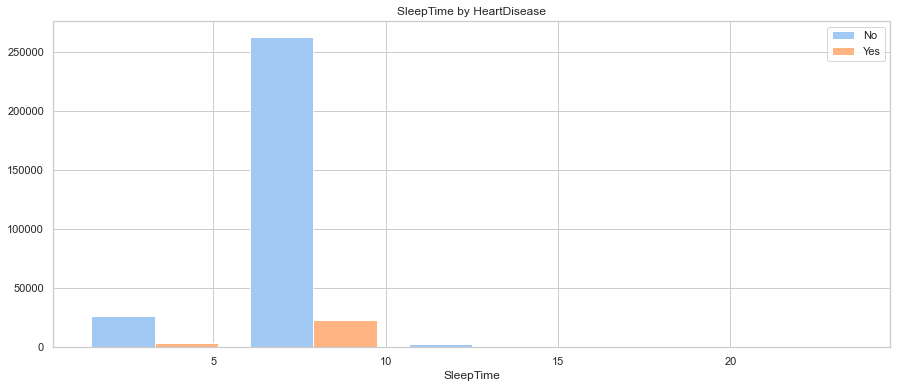

In [12]:
# distribution of features by HeartDisease
for col in columns:
    if df[col].nunique() > 2:
        split_hist(df, col, split_by='HeartDisease', bins=5, figsize=(15,6))

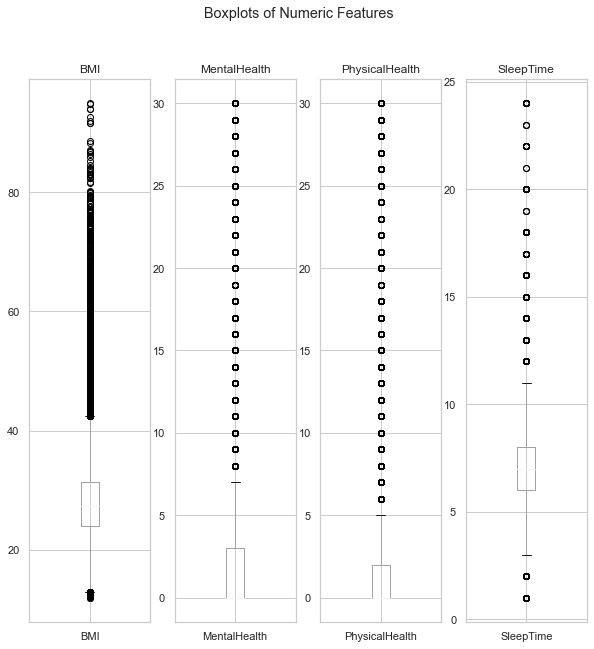

In [13]:
# boxplot distributions for numeric features
fig, ax = plt.subplots(1,4, figsize=(10,10))
df[['BMI']].boxplot(ax=ax[0])
ax[0].set_title('BMI')
df[['MentalHealth']].boxplot(ax=ax[1])
ax[1].set_title('MentalHealth')
df[['PhysicalHealth']].boxplot(ax=ax[2])
ax[2].set_title('PhysicalHealth')
df[['SleepTime']].boxplot(ax=ax[3])
ax[3].set_title('SleepTime')
plt.suptitle('Boxplots of Numeric Features')
plt.show()

There doesn't appear to be any null values or values that obviously do not belong. While the cutoff for type III obesity is 40, a BMI of 90 is plausible because it is the BMI of a person who weighs 400 lbs at 4 foot 8 or 657 lbs at 6 feet tall.

BMI = kg/(m^2)

The data are very unbalanced with a vast majority of instances reporting 'No' for our target feature, 'HeartDisease'.

## Handling imbalanced data

After undersampling: Counter({'No': 27373, 'Yes': 27373})


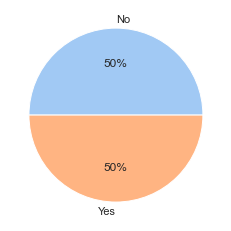

In [14]:
# Oversample and undersample and look at distributions.
# Undersample removes samples randomly from the majority class to make the distribution more equal
# As usual, X is all minus target variable
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_under, y_under = under_sampler.fit_resample(X, y)

# Count classes and create pie chart
print(f'After undersampling: {Counter(y_under)}')
plt.pie(y_under.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

In [15]:
X_under.describe(include='all')

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,...,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,SleepTime_binned,BMI_binned,MentalHealth_binned,PhysicalHealth_binned
count,54746.000000,54746,54746,54746,54746.000000,54746.000000,54746,54746,54746,54746,...,54746,54746,54746.000000,54746,54746,54746,54746,54746,54746,54746
unique,NaN,2,2,2,NaN,NaN,2,2,13,6,...,2,5,NaN,2,2,2,4,6,4,4
top,NaN,No,No,No,NaN,NaN,No,Male,70-74,White,...,Yes,Good,NaN,No,No,No,> 5 to ≤ 7 h,Overweight,≤ 7 days,≤ 7 days
freq,NaN,27923,51653,49659,NaN,NaN,41548,28918,7224,43328,...,38974,17413,NaN,46308,50533,47412,26011,19915,45193,43386
mean,28.792460,NaN,NaN,NaN,5.371223,4.241771,NaN,NaN,NaN,NaN,...,NaN,NaN,7.118164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.470628,NaN,NaN,NaN,9.954864,8.553142,NaN,NaN,NaN,NaN,...,NaN,NaN,1.597540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12.210000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,24.390000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,27.710000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,32.010000,NaN,NaN,NaN,5.000000,3.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After oversampling: Counter({'No': 292422, 'Yes': 292422})


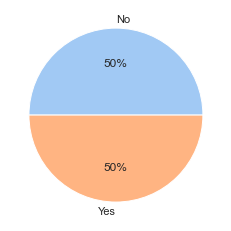

In [16]:
# oversampling randomly chooses and adds in samples from minority class to make distribution more equal
over_sampler = RandomOverSampler(sampling_strategy='minority', random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_over, y_over = over_sampler.fit_resample(X, y)

print(f'After oversampling: {Counter(y_over)}')
plt.pie(y_over.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

In [17]:
X_over.describe(include='all')

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,...,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,SleepTime_binned,BMI_binned,MentalHealth_binned,PhysicalHealth_binned
count,584844.000000,584844,584844,584844,584844.000000,584844.000000,584844,584844,584844,584844,...,584844,584844,584844.000000,584844,584844,584844,584844,584844,584844,584844
unique,NaN,2,2,2,NaN,NaN,2,2,13,6,...,2,5,NaN,2,2,2,4,6,4,4
top,NaN,No,No,No,NaN,NaN,No,Male,70-74,White,...,Yes,Good,NaN,No,No,No,> 5 to ≤ 7 h,Overweight,≤ 7 days,≤ 7 days
freq,NaN,297855,552085,530072,NaN,NaN,443255,308059,77870,463404,...,417394,185962,NaN,494002,539414,506541,277994,211296,482621,462973
mean,28.808107,NaN,NaN,NaN,5.390971,4.240462,NaN,NaN,NaN,NaN,...,NaN,NaN,7.115034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.475100,NaN,NaN,NaN,9.969421,8.535121,NaN,NaN,NaN,NaN,...,NaN,NaN,1.603945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12.020000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,24.390000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,27.750000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,32.080000,NaN,NaN,NaN,5.000000,3.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# will move forward with undersampled df and explore oversampled df model performance later
y_under = pd.DataFrame(y_under)
undersampled_df = y_under.merge(X_under, left_index=True, right_index=True)
df = undersampled_df

## Exploring resampled data

In [19]:
df.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.121185,0.069538,-0.040848
PhysicalHealth,0.121185,1.000000,0.323493,-0.068301
MentalHealth,0.069538,0.323493,1.000000,-0.119339
SleepTime,-0.040848,-0.068301,-0.119339,1.000000


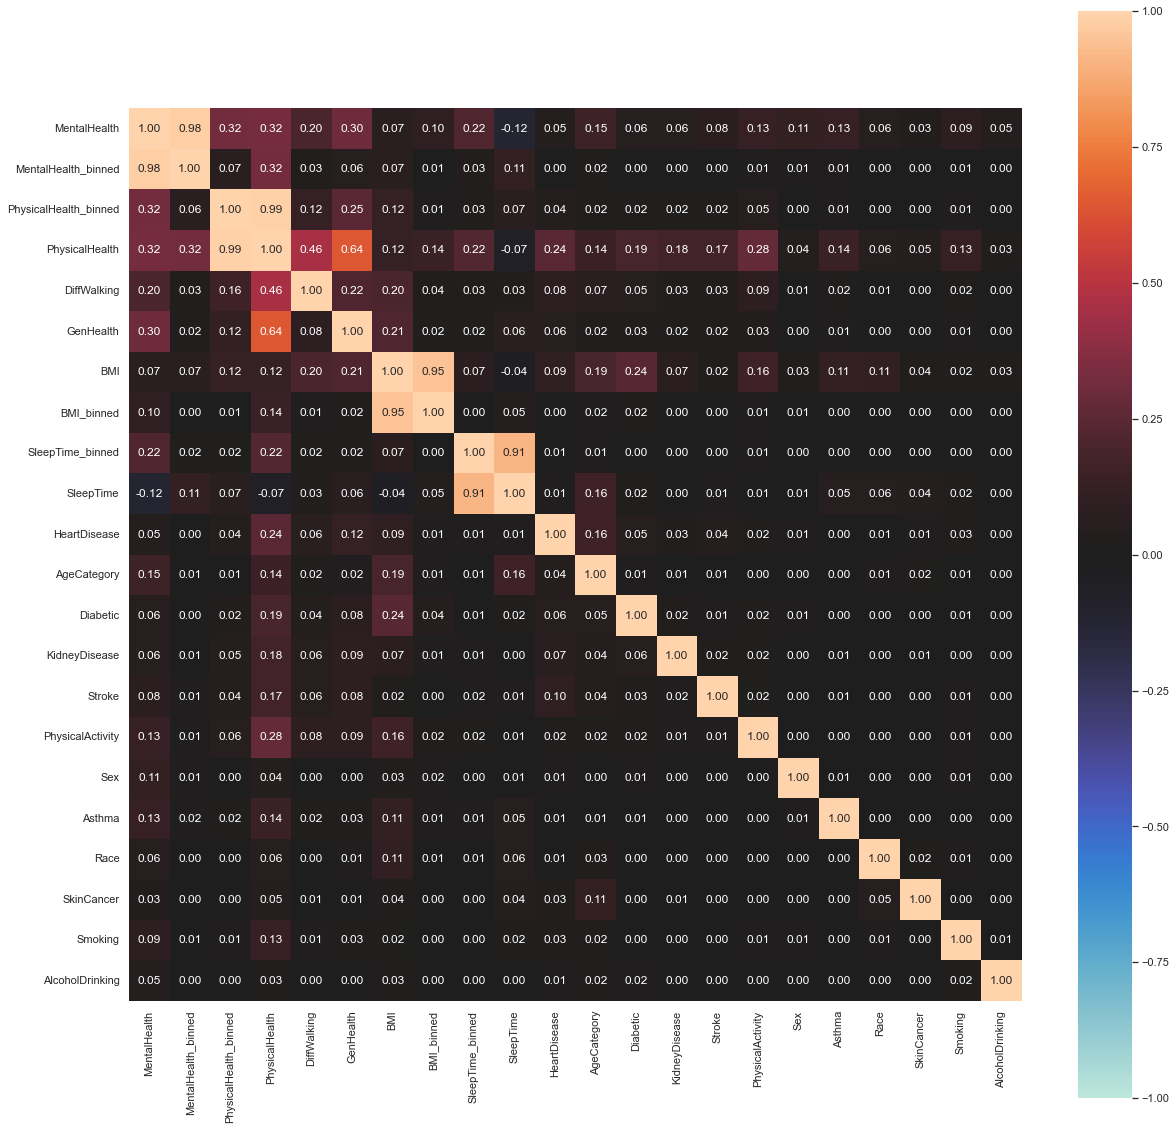

{'corr':                        MentalHealth  MentalHealth_binned  \
 MentalHealth               1.000000             0.981155   
 MentalHealth_binned        0.981155             1.000000   
 PhysicalHealth_binned      0.318944             0.062714   
 PhysicalHealth             0.323493             0.320235   
 DiffWalking                0.196699             0.031043   
 GenHealth                  0.297367             0.024597   
 BMI                        0.069538             0.069094   
 BMI_binned                 0.097781             0.002742   
 SleepTime_binned           0.216154             0.016930   
 SleepTime                 -0.119339             0.113252   
 HeartDisease               0.046766             0.002927   
 AgeCategory                0.154881             0.005307   
 Diabetic                   0.060234             0.002914   
 KidneyDisease              0.057184             0.005716   
 Stroke                     0.078012             0.008721   
 PhysicalActivit

In [20]:
# make all categorical features type object to work with dython.nominal.associations
df[['SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned']] = \
                    df[['SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned']].astype(object)
# dython.nominal.associations easily displays correlation heatmap of categorical and numeric features
assoc = associations(df, nom_nom_assoc='theil', clustering=True, figsize=(20,20))
assoc

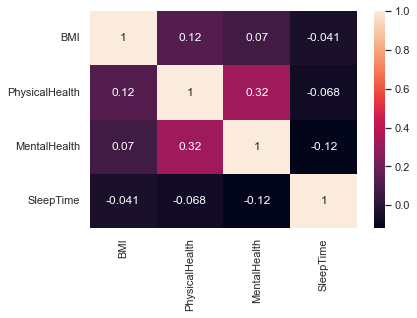

In [21]:
fig, ax = plt.subplots()
ax = sns.heatmap(df.corr(), annot=True)

PhysicalHealth and MentalHealth are positively correlated, as is DiffWalking and PhysicalHealth, though with correlations under 0.5, likely not too correlated to cause an issue with modeling collinearly. 

GenHealth and PhysicalHealth are the most correlated column (other than features generated from other features). 
0.64 may be significant, may need to drop one of these columns to avoid issue.

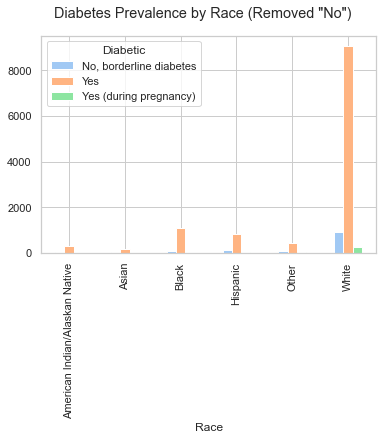

In [22]:
racediabetic = pd.crosstab(df['Race'], df['Diabetic'])
racediabetic = pd.DataFrame(racediabetic)
racediabetic[['No, borderline diabetes', 'Yes', 'Yes (during pregnancy)']].plot(kind='bar')
plt.suptitle('Diabetes Prevalence by Race (Removed "No")')
plt.show()

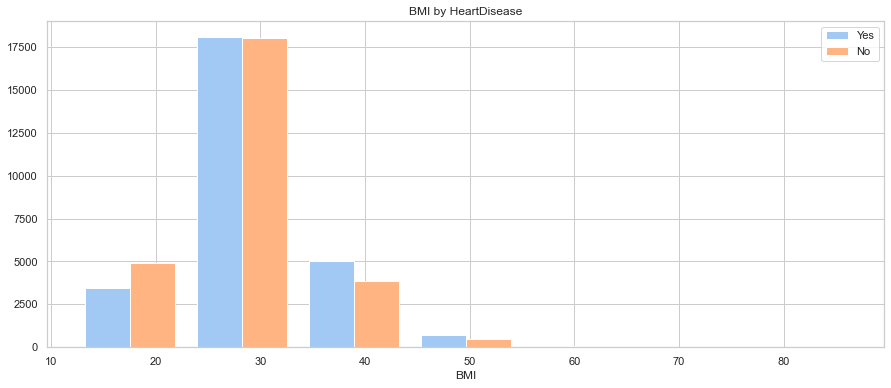

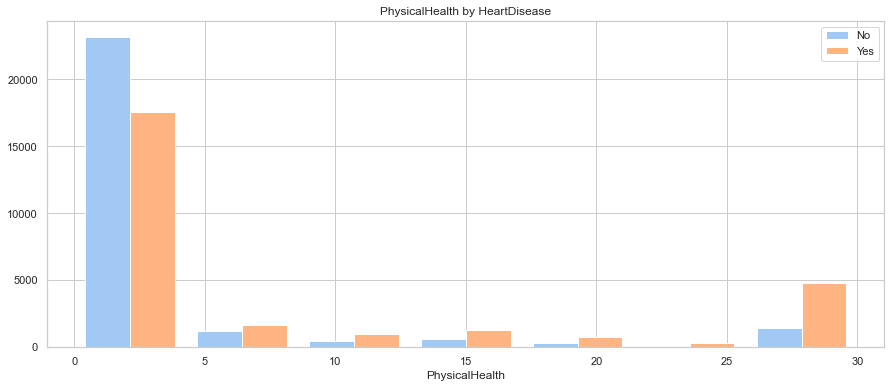

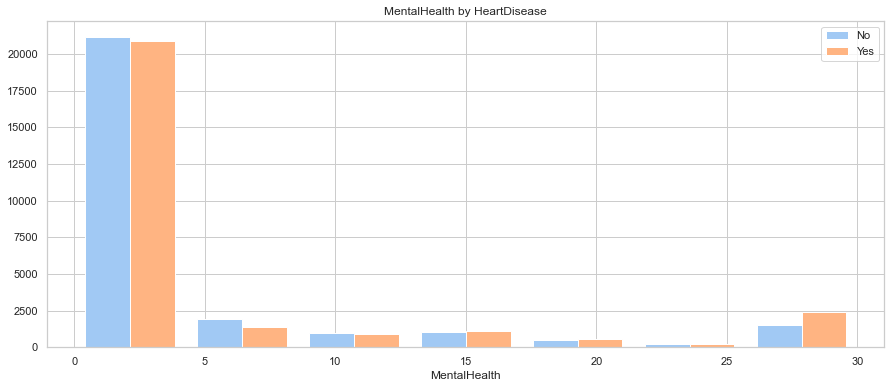

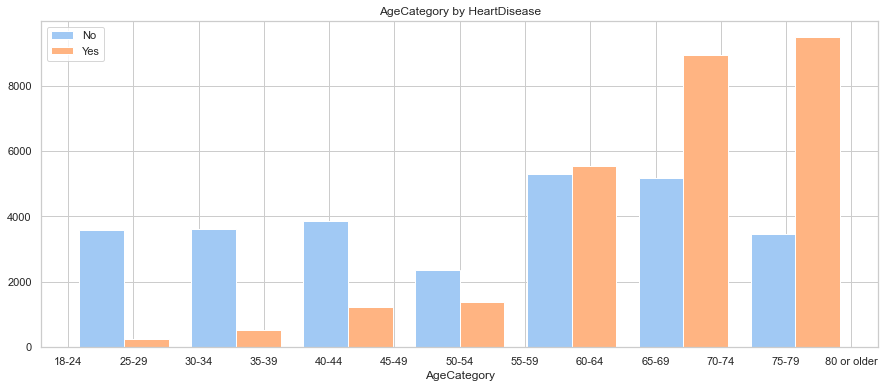

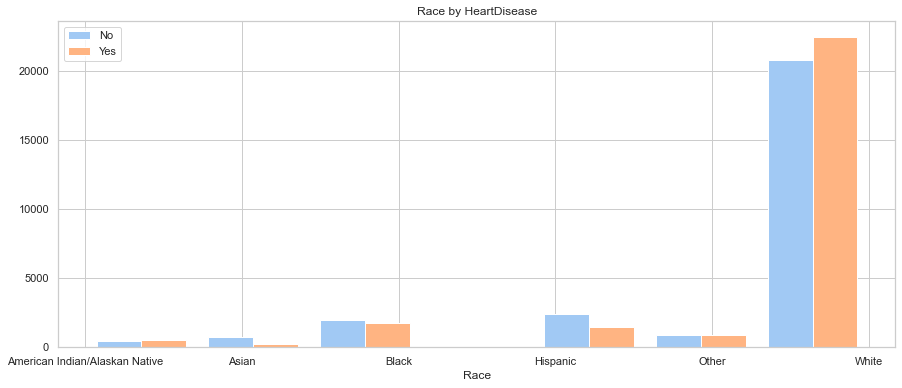

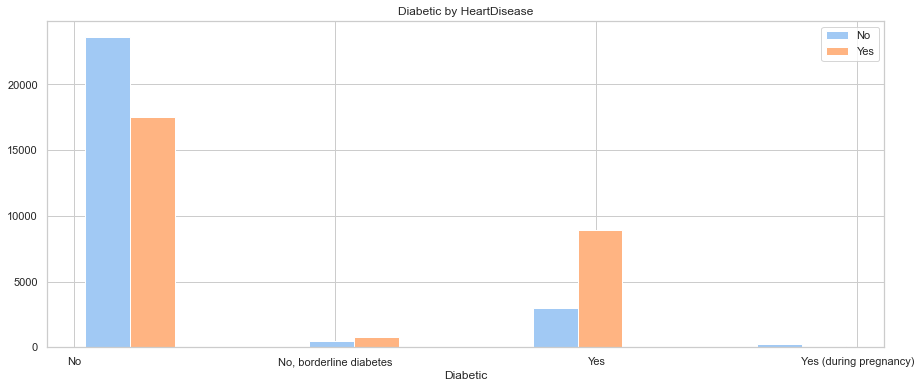

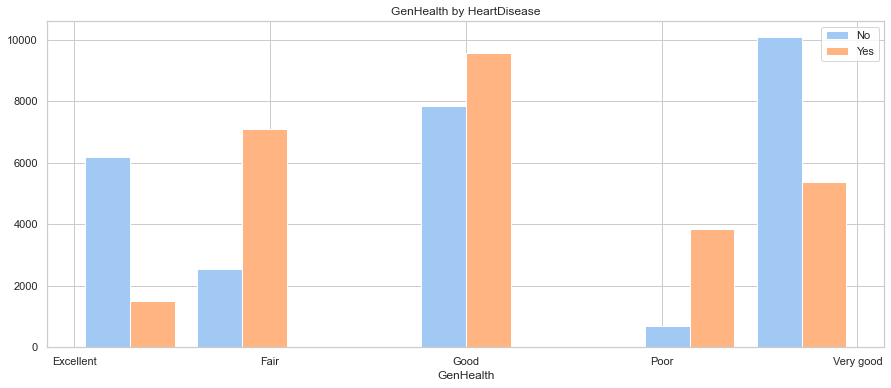

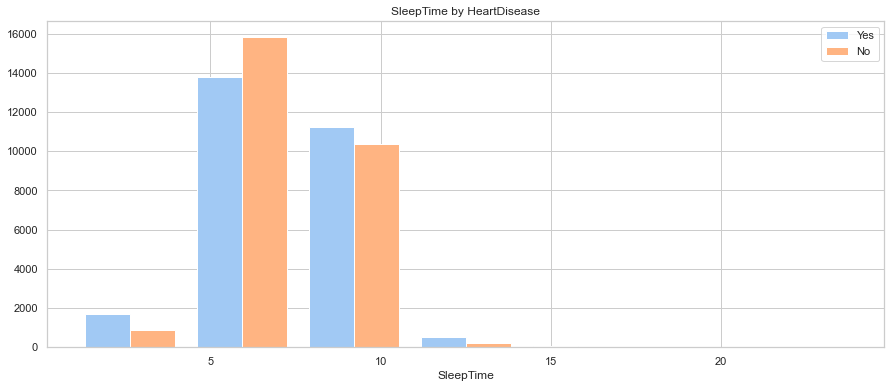

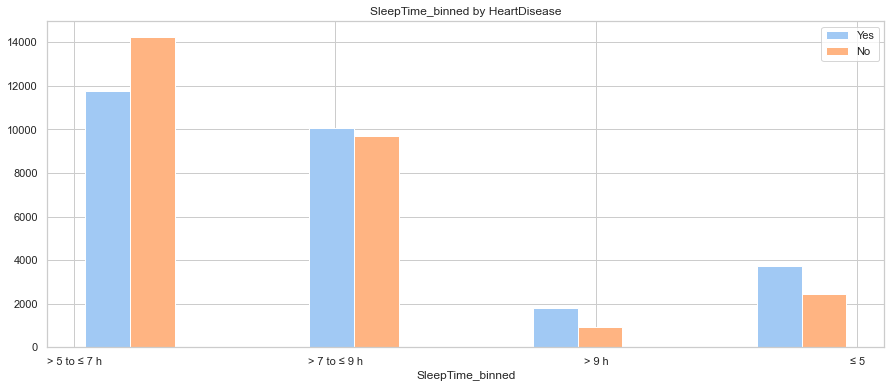

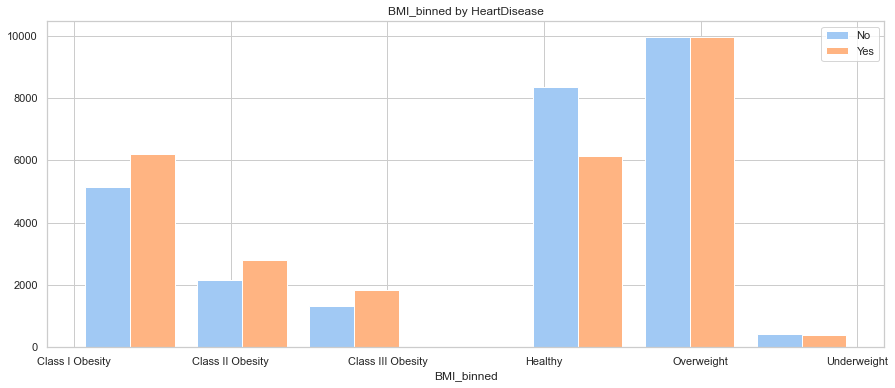

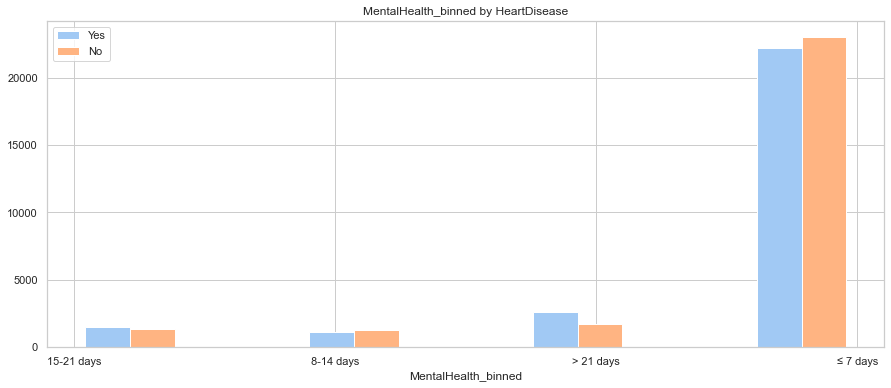

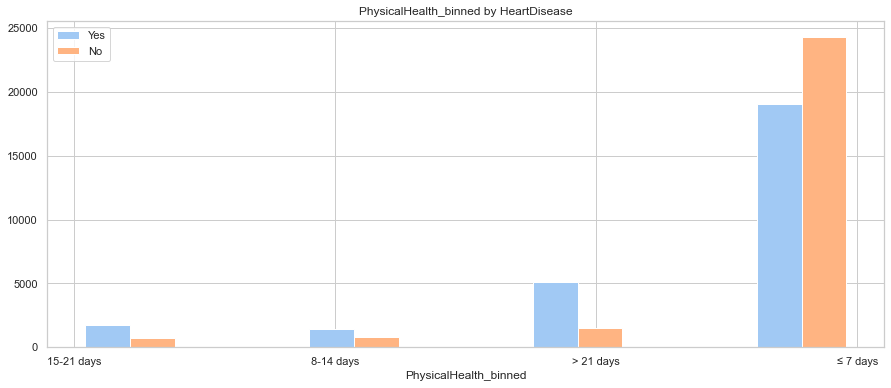

In [23]:
# distribution of features by HeartDisease
for col in df.columns:
    if df[col].nunique() > 2:
        data = df.sort_values(col)
        split_hist(data, col, split_by='HeartDisease', bins=7, figsize=(15,6))

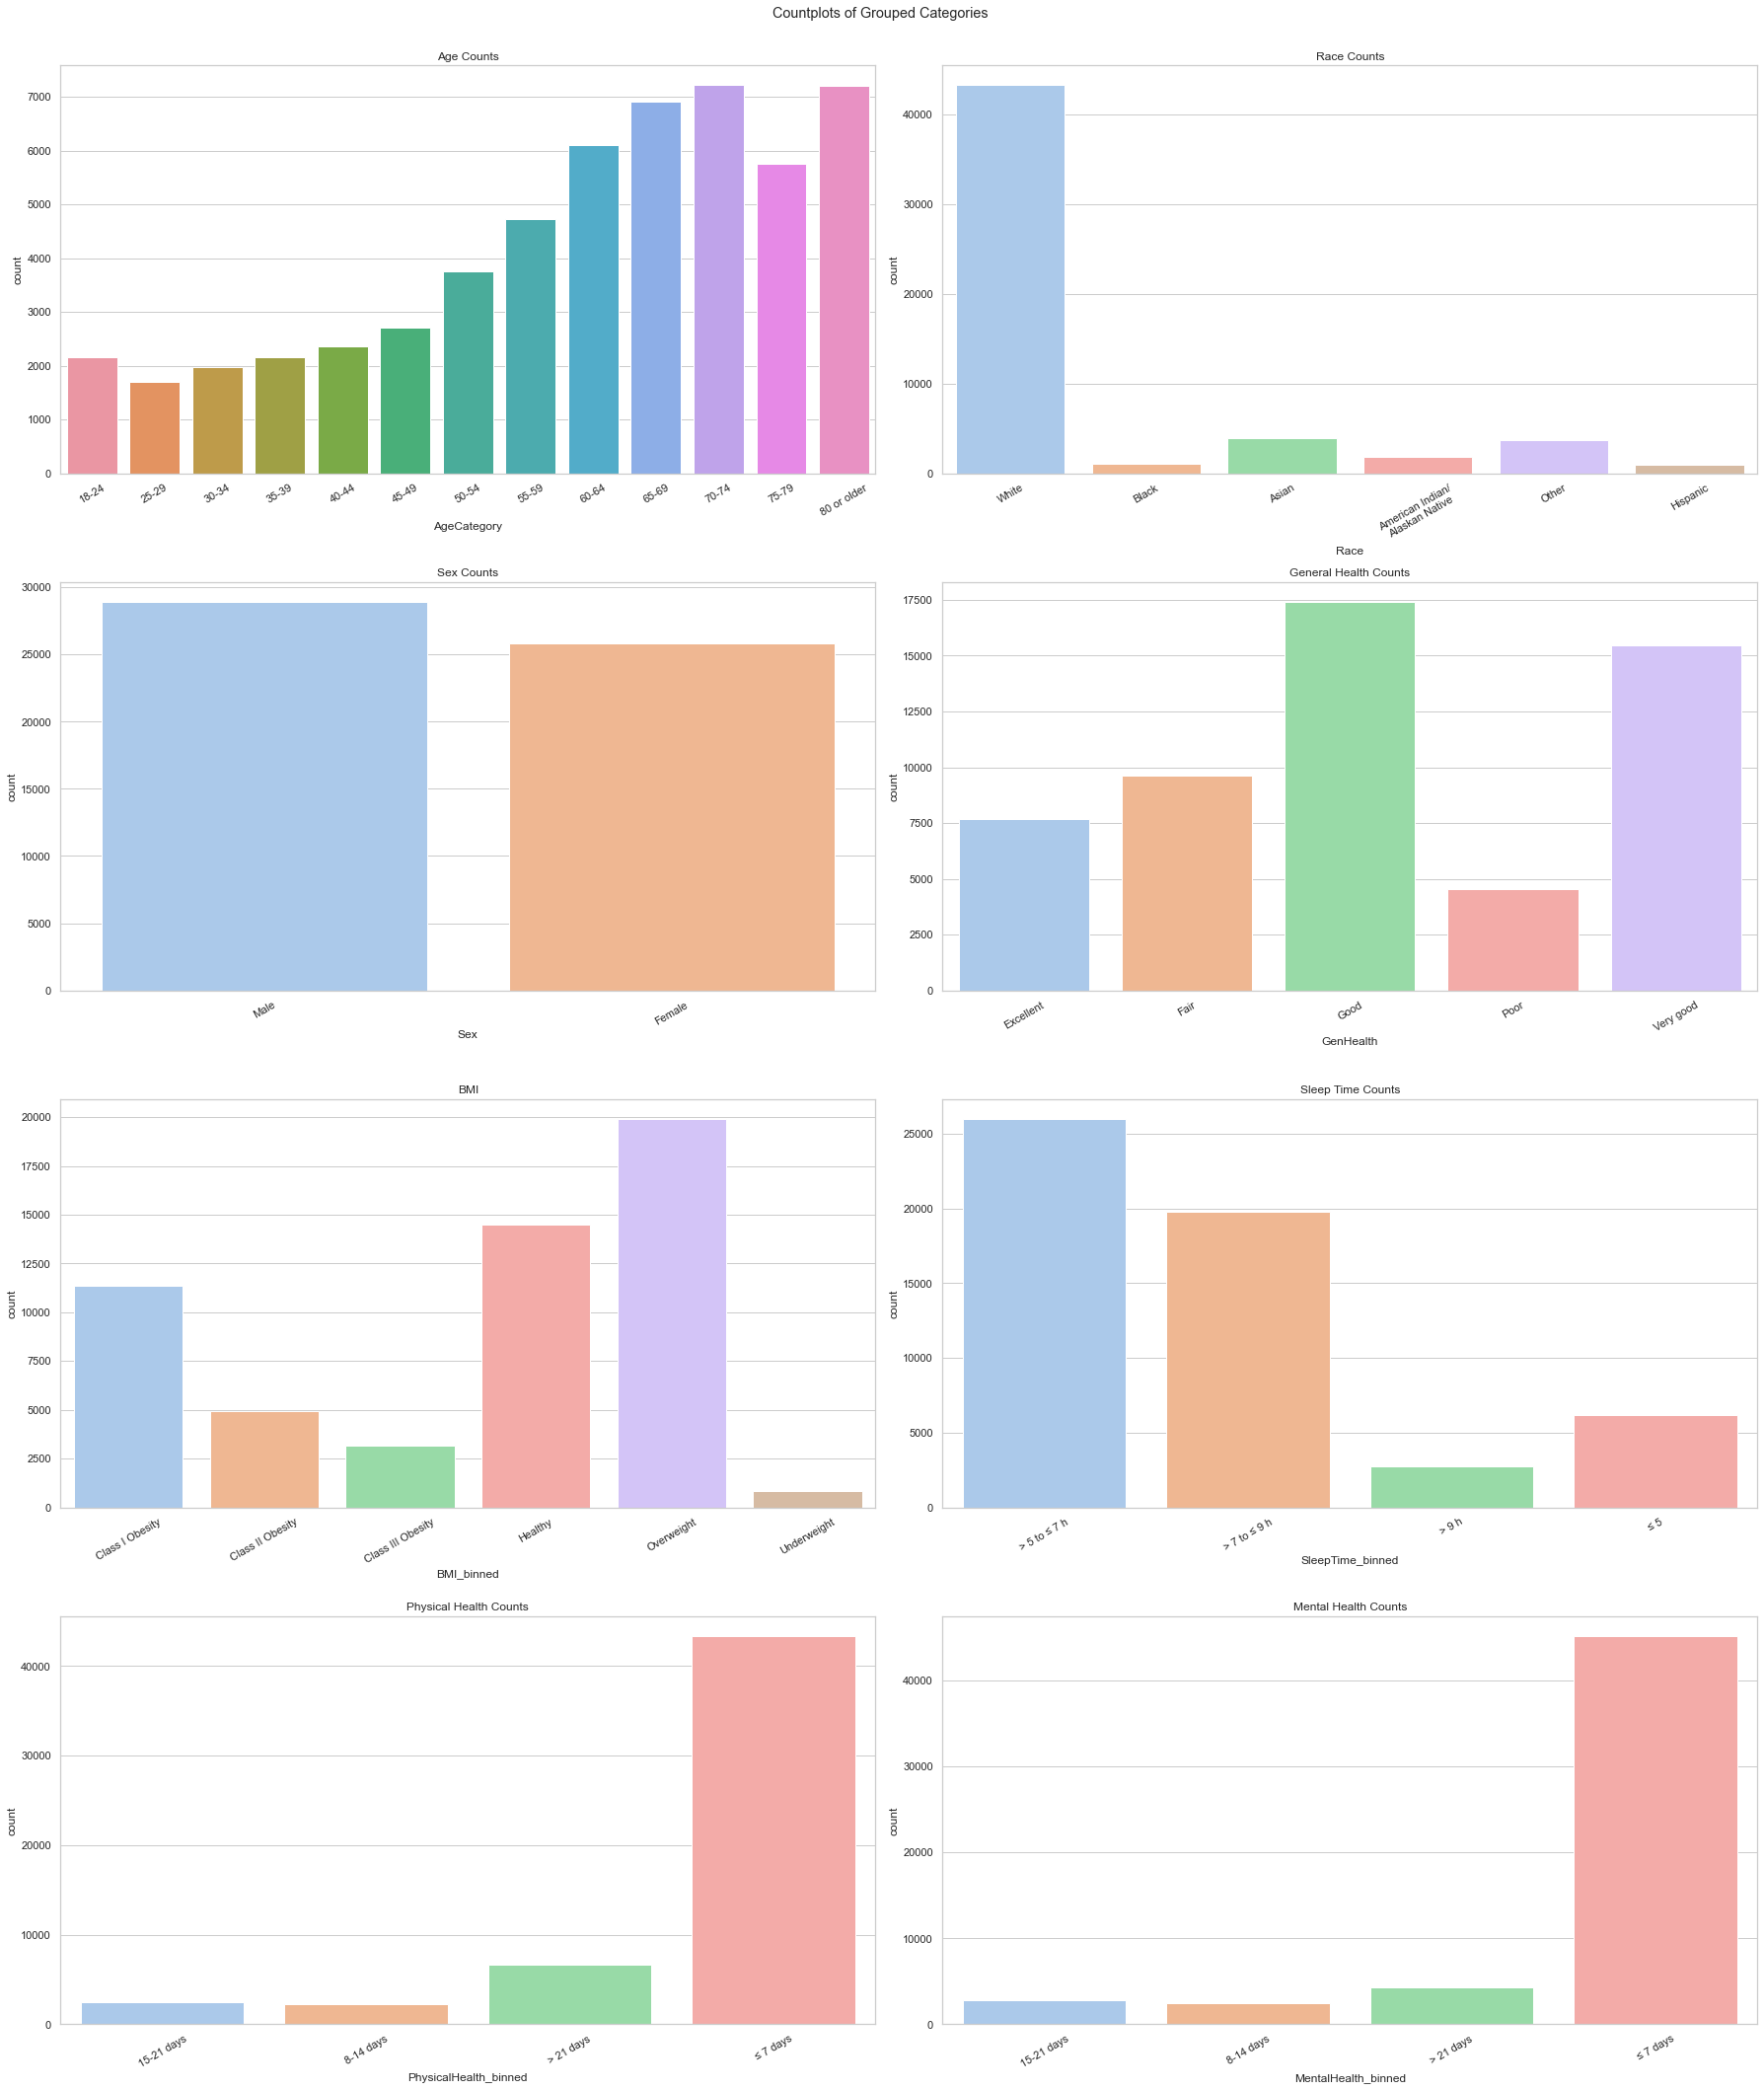

In [24]:
# binned countplots
fig, ax = plt.subplots(4, 2, figsize=(25,30))
plt.suptitle('Countplots of Grouped Categories \n \n \n')
           
age_dist = sns.countplot(x = df.sort_values('AgeCategory')['AgeCategory'], ax=ax[0][0])
age_dist.set_xticklabels(labels=df.sort_values('AgeCategory')['AgeCategory'].unique(), rotation=30)
age_dist.set_title('Age Counts')

race_dist = sns.countplot(x = df['Race'], ax=ax[0][1])
race_dist.set_xticklabels(labels=['White', 'Black', 'Asian', 'American Indian/\nAlaskan Native','Other', 'Hispanic'], rotation=30) 
race_dist.set_title('Race Counts')


sex_dist = sns.countplot(x = df['Sex'], ax=ax[1][0])
sex_dist.set_xticklabels(labels=df['Sex'].unique(), rotation=30) 
sex_dist.set_title('Sex Counts')


genhealth_dist = sns.countplot(x = df.sort_values('GenHealth')['GenHealth'], ax=ax[1][1])
genhealth_dist.set_xticklabels(labels=df.sort_values('GenHealth')['GenHealth'].unique(), rotation=30)
genhealth_dist.set_title('General Health Counts')


bmibin_dist = sns.countplot(x = df.sort_values('BMI_binned')['BMI_binned'], ax=ax[2][0])
bmibin_dist.set_xticklabels(labels=df.sort_values('BMI_binned')['BMI_binned'].unique(), rotation=30)
bmibin_dist.set_title('BMI')


sleepbin_dist = sns.countplot(x = df.sort_values('SleepTime_binned')['SleepTime_binned'], ax=ax[2][1])
sleepbin_dist.set_xticklabels(labels=df.sort_values('SleepTime_binned')['SleepTime_binned'].unique(), rotation=30)
sleepbin_dist.set_title('Sleep Time Counts')


physicalbin_dist = sns.countplot(x = df.sort_values('PhysicalHealth_binned')['PhysicalHealth_binned'], ax=ax[3][0])
physicalbin_dist.set_xticklabels(labels=df.sort_values('PhysicalHealth_binned')['PhysicalHealth_binned'].unique(), rotation=30)
physicalbin_dist.set_title('Physical Health Counts')


mentalbin_dist = sns.countplot(x = df.sort_values('MentalHealth_binned')['MentalHealth_binned'], ax=ax[3][1])
mentalbin_dist.set_xticklabels(labels=df.sort_values('MentalHealth_binned')['MentalHealth_binned'].unique(), rotation=30)
mentalbin_dist.set_title('Mental Health Counts')
fig.tight_layout()
plt.show()

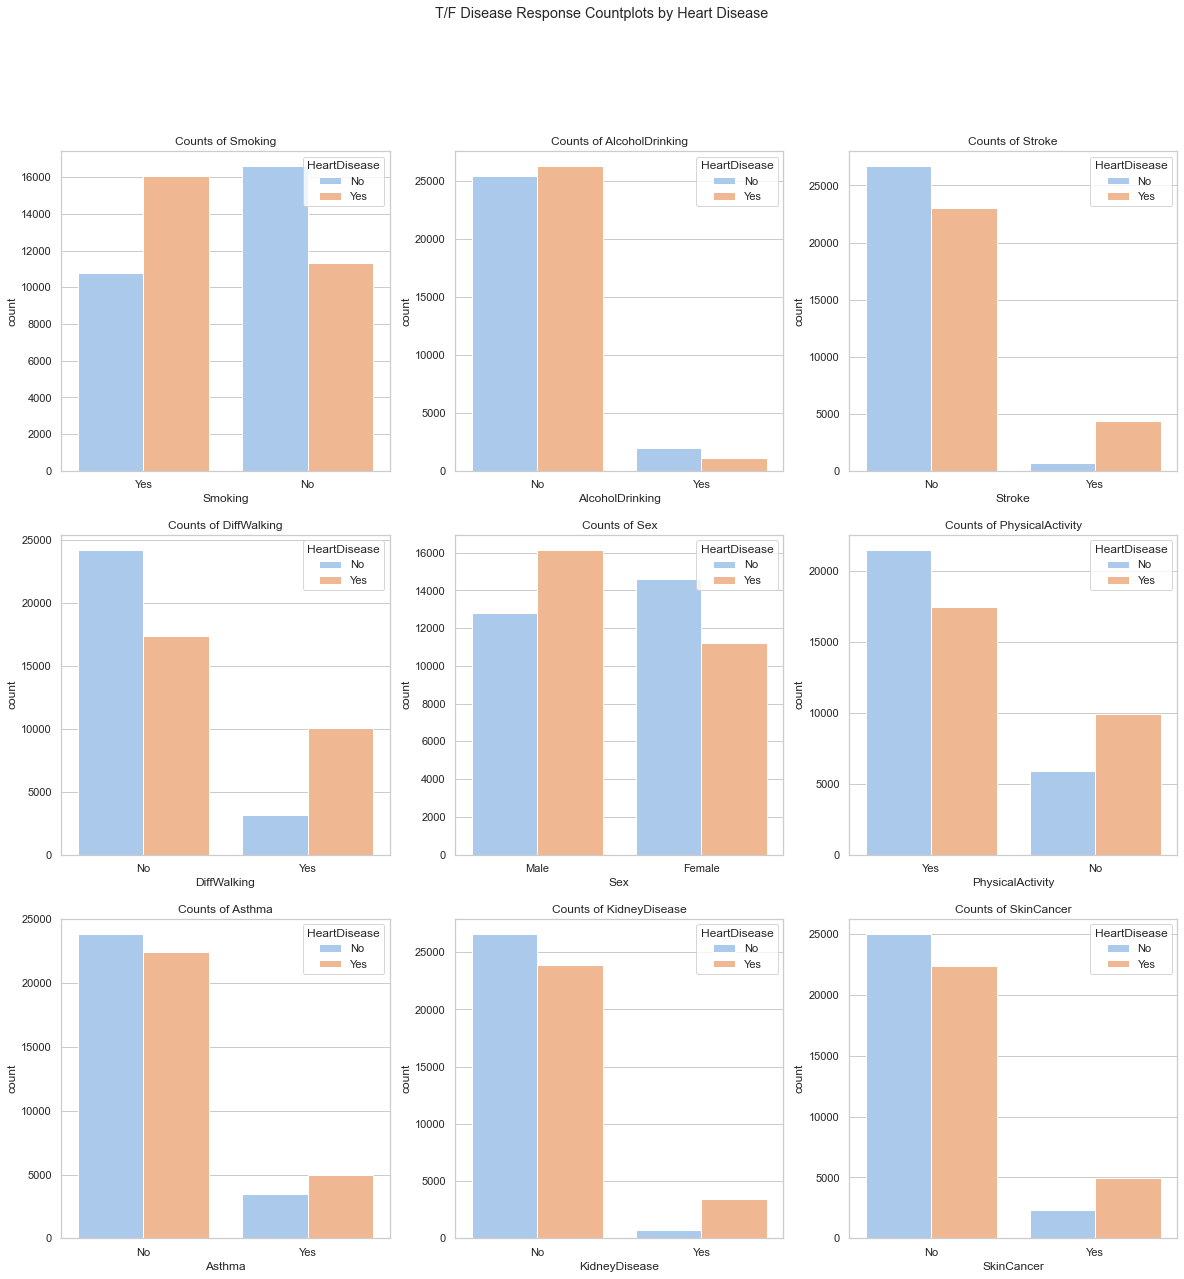

In [25]:
# boolean (T/F response columns) countplots by HeartDisease
bool_cols = [['Smoking','AlcoholDrinking','Stroke'],['DiffWalking','Sex','PhysicalActivity'],['Asthma','KidneyDisease','SkinCancer']]

def countplots(cols):
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    plt.suptitle("T/F Disease Response Countplots by Heart Disease")
    for row in range(3):
        for col in range(3):
            column = bool_cols[row][col]
            sns.countplot(x=df[column],ax=axes[row,col],hue=df['HeartDisease']).set(title="Counts of {}".format(column))

countplots(bool_cols)

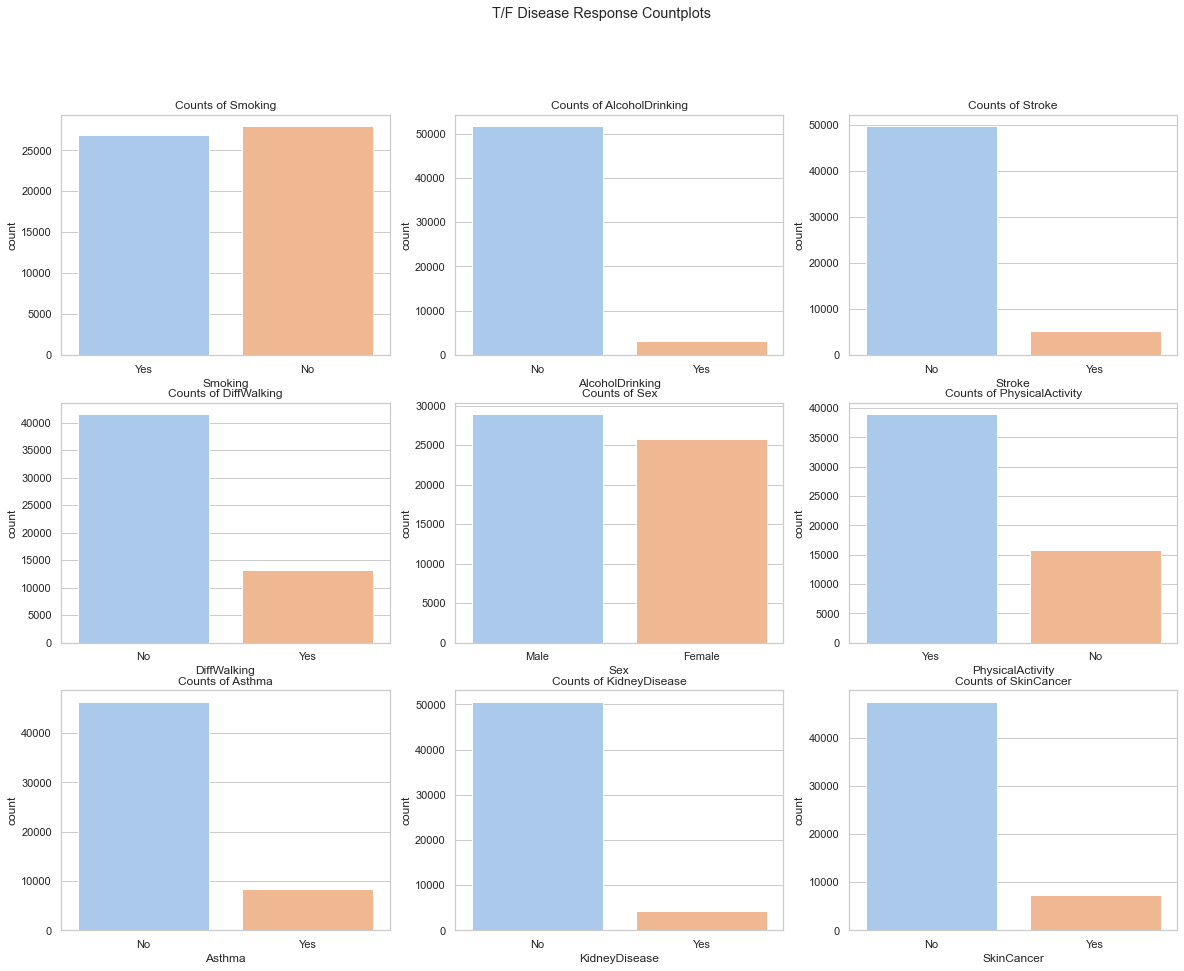

In [26]:
# boolean countplots 
def counts(cols):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle("T/F Disease Response Countplots")
    for row in range(3):
        for col in range(3):
            column = bool_cols[row][col]
            sns.countplot(x=df[column],ax=axes[row,col]).set(title="Counts of {}".format(column))

counts(bool_cols)

In [27]:
print(f'min BMI: {df["BMI"].min()}')
print(f'max BMI: {df["BMI"].max()}')

min BMI: 12.21
max BMI: 87.05


In [28]:
len(df)

54746

## Preprocessing

Encode and standardize the data.

In [29]:
# label encode cols with 2 or less options
lencoder = LabelEncoder()
columns = ['Sex', 'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'AgeCategory']
for col in columns:
        df[col] = lencoder.fit_transform(df[col])
# onehot encode variables nunique > 2 -- model accuracies lower with onehot encoded 'AgeCategory'
df = pd.get_dummies(df, columns=['Race', 'Diabetic', 'GenHealth'], prefix=['Race', 'Diabetic', 'GenHealth'])
# add binned columns to df for modeling
binned_cols = ['SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned']
for col in binned_cols:
        df[col] = lencoder.fit_transform(df[col])

In [30]:
#df = df.drop(columns=['SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned'])
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,34.87,1,0,0,0,0,0,1,9,...,1,1,0,0,0,0,0,0,0,1
1,0,28.89,0,0,0,0,0,0,1,3,...,0,1,0,0,0,1,0,0,0,0
2,0,25.68,0,0,0,0,0,0,1,3,...,1,1,0,0,0,0,0,0,0,1
3,0,28.08,0,0,0,1,10,0,1,1,...,1,1,0,0,0,0,0,0,0,1
4,0,28.67,0,0,0,30,30,1,0,10,...,1,1,0,0,0,0,1,0,0,0


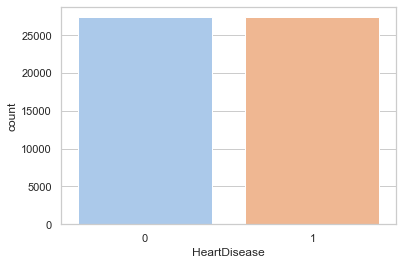

In [31]:
# train_test_split (before scaler)
X = df.iloc[:, 1:]
y = df['HeartDisease']

# confirm balance
sns.countplot(x=y, data=df)
plt.show()

In [32]:
len(X)

54746

In [33]:
# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [34]:
# outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers -- -1 is outlier 
mask = yhat != -1
X_train, y_train = X_train.iloc[mask], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(43614, 33) (43614,)


In [35]:
num_removed = len(yhat) - np.count_nonzero(yhat==1)
num_removed

182

Removed 182 rows of data identified as outliers by LocalOutlierFactor. 

In [36]:
# separate numerical columns to be scaled
num_train_df = X_train[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']]
num_test_df = X_test[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']]

# fit scaler on training data and only transform test data
# scale after train_test_split to avoid causing data leakage
scaler = StandardScaler()

X_train_num = scaler.fit(num_train_df)
X_train_num = scaler.transform(num_train_df)
X_test_num = scaler.transform(num_test_df)

# Add column names and convert to df
col_names = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
X_train_num = pd.DataFrame(X_train_num, columns=col_names)
X_test_num = pd.DataFrame(X_test_num, columns=col_names)

In [37]:
# merge cat and num dataframes
X_train = X_train.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'])
X_train = X_train.reset_index(drop=True)
X_train = X_train.merge(X_train_num, left_index=True, right_index=True)

X_test = X_test.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'])
X_test = X_test.reset_index(drop=True)
X_test = X_test.merge(X_test_num, left_index=True, right_index=True)

Feature selection with cross validation

In [38]:
# feature selection with lasso regularization 
# compare with result of alpha from LassoCV

alphas = np.arange(0.1,10,0.1)
lassocv = LassoCV(alphas=alphas, verbose = 2, random_state = 45)
lassocv.fit(X_train, y_train)

Path: 000 out of 099
Path: 001 out of 099
Path: 002 out of 099
Path: 003 out of 099
Path: 004 out of 099
Path: 005 out of 099
Path: 006 out of 099
Path: 007 out of 099
Path: 008 out of 099
Path: 009 out of 099
Path: 010 out of 099
Path: 011 out of 099
Path: 012 out of 099
Path: 013 out of 099
Path: 014 out of 099
Path: 015 out of 099
Path: 016 out of 099
Path: 017 out of 099
Path: 018 out of 099
Path: 019 out of 099
Path: 020 out of 099
Path: 021 out of 099
Path: 022 out of 099
Path: 023 out of 099
Path: 024 out of 099
Path: 025 out of 099
Path: 026 out of 099
Path: 027 out of 099
Path: 028 out of 099
Path: 029 out of 099
Path: 030 out of 099
Path: 031 out of 099
Path: 032 out of 099
Path: 033 out of 099
Path: 034 out of 099
Path: 035 out of 099
Path: 036 out of 099
Path: 037 out of 099
Path: 038 out of 099
Path: 039 out of 099
Path: 040 out of 099
Path: 041 out of 099
Path: 042 out of 099
Path: 043 out of 099
Path: 044 out of 099
Path: 045 out of 099
Path: 046 out of 099
Path: 047 out

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Path: 000 out of 099
Path: 001 out of 099
Path: 002 out of 099
Path: 003 out of 099
Path: 004 out of 099
Path: 005 out of 099
Path: 006 out of 099
Path: 007 out of 099
Path: 008 out of 099
Path: 009 out of 099
Path: 010 out of 099
Path: 011 out of 099
Path: 012 out of 099
Path: 013 out of 099
Path: 014 out of 099
Path: 015 out of 099
Path: 016 out of 099
Path: 017 out of 099
Path: 018 out of 099
Path: 019 out of 099
Path: 020 out of 099
Path: 021 out of 099
Path: 022 out of 099
Path: 023 out of 099
Path: 024 out of 099
Path: 025 out of 099
Path: 026 out of 099
Path: 027 out of 099
Path: 028 out of 099
Path: 029 out of 099
Path: 030 out of 099
Path: 031 out of 099
Path: 032 out of 099
Path: 033 out of 099
Path: 034 out of 099
Path: 035 out of 099
Path: 036 out of 099
Path: 037 out of 099
Path: 038 out of 099
Path: 039 out of 099
Path: 040 out of 099
Path: 041 out of 099
Path: 042 out of 099
Path: 043 out of 099
Path: 044 out of 099
Path: 045 out of 099
Path: 046 out of 099
Path: 047 out

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


LassoCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
        random_state=45, verbose=2)

In [39]:
print(f'lassocv coef > 0 : {np.sum(lassocv.coef_ > 0)}')
feature_names = lassocv.feature_names_in_[lassocv.coef_ > 0]
print(f'features with lassocv coef > 0: {feature_names}')
print(lassocv.coef_ > 0)
print(f'alpha: {lassocv.alpha_}')
lasso_mse_path = lassocv.mse_path_
print(f'num features in: {lassocv.n_features_in_}')
print(f'score: {lassocv.score(X_test,y_test)}')

lassocv coef > 0 : 1
features with lassocv coef > 0: ['AgeCategory']
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
alpha: 0.1
num features in: 33
score: 0.1930098838293558


In [40]:
# feature selection with RidgeCV 

ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(X_train, y_train)

print(f'ridgecv coef > 0 : {np.sum(ridgecv.coef_ > 0)}')
feature_names = ridgecv.feature_names_in_[ridgecv.coef_ > 0]
print(f'features with ridgecv coef > 0: {feature_names}')
print(f'alpha: {ridgecv.alpha_}')
print(f'num features: {ridgecv.n_features_in_}')
print(f'score: {ridgecv.score(X_test,y_test)}')
print(f'best score: {ridgecv.best_score_}')
drop_features = lassocv.feature_names_in_[lassocv.coef_ <= 0]
print(f'features with ridgecv coef < 0: {drop_features}')

ridgecv coef > 0 : 22
features with ridgecv coef > 0: ['Smoking' 'Stroke' 'DiffWalking' 'Sex' 'AgeCategory' 'PhysicalActivity'
 'Asthma' 'KidneyDisease' 'SkinCancer' 'SleepTime_binned'
 'Race_American Indian/Alaskan Native' 'Race_Hispanic' 'Race_Other'
 'Race_White' 'Diabetic_No, borderline diabetes' 'Diabetic_Yes'
 'GenHealth_Fair' 'GenHealth_Good' 'GenHealth_Poor' 'BMI' 'PhysicalHealth'
 'MentalHealth']
alpha: 9.9
num features: 33
score: 0.3491083021034158
best score: -0.1667415826455729
features with ridgecv coef < 0: ['Smoking' 'AlcoholDrinking' 'Stroke' 'DiffWalking' 'Sex'
 'PhysicalActivity' 'Asthma' 'KidneyDisease' 'SkinCancer'
 'SleepTime_binned' 'BMI_binned' 'MentalHealth_binned'
 'PhysicalHealth_binned' 'Race_American Indian/Alaskan Native'
 'Race_Asian' 'Race_Black' 'Race_Hispanic' 'Race_Other' 'Race_White'
 'Diabetic_No' 'Diabetic_No, borderline diabetes' 'Diabetic_Yes'
 'Diabetic_Yes (during pregnancy)' 'GenHealth_Excellent' 'GenHealth_Fair'
 'GenHealth_Good' 'GenHealth_Po

After testing, higher accuracy models obtained with OneHot encoded GenHealth column vs label encoding. 

Can show that using AgeCategory alone gets 63% accurate model, why?

Modeling only features selected by RidgeCV results in slightly lower accuracies for LogReg models. 

## Modeling

For example, if you’re writing a classification model, you should
implement both an entropy model and a Gini impurity model. For hyperparameter tuning, think of methods like cross-validation.

Do LogReg for linear relationship to understand feature more

**Logistic Regression**

A comparison of different penalty options on optimization

In [41]:
# starting off simple with a linear model - LogReg

lr = LogisticRegression(random_state=123, max_iter=300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('LogReg1 no penalty model \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Classification report: \n{classification_report(y_test, y_pred, digits=5)}')

y_hat = lr.predict(X_train)
print(f'LogReg training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg test set accuracy: {accuracy_score(y_test, y_pred)}')

LogReg1 no penalty model 

Confusion matrix: 
[[4196 1387]
 [1134 4233]]
Classification report: 
              precision    recall  f1-score   support

           0    0.78724   0.75157   0.76899      5583
           1    0.75320   0.78871   0.77055      5367

    accuracy                        0.76977     10950
   macro avg    0.77022   0.77014   0.76977     10950
weighted avg    0.77056   0.76977   0.76975     10950

LogReg training set accuracy: 0.762209382308433
LogReg test set accuracy: 0.7697716894977169


In [42]:
# Logistic Regression with l1 regularization (Lasso) 
lr2 = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=5, random_state=45)
lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)

cm2 = confusion_matrix(y_test, y_pred2)

print('LogReg2 Lasso model \n')
print(f'Confusion matrix: \n{cm2}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred2, digits=5)}')

# model evaluation against test set
y_hat = lr2.predict(X_train)
print(f'LogReg2 training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg2 test set accuracy: {accuracy_score(y_test, y_pred2)}')

LogReg2 Lasso model 

Confusion matrix: 
[[4198 1385]
 [1133 4234]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78747   0.75193   0.76929      5583
           1    0.75351   0.78890   0.77080      5367

    accuracy                        0.77005     10950
   macro avg    0.77049   0.77041   0.77004     10950
weighted avg    0.77083   0.77005   0.77003     10950

LogReg2 training set accuracy: 0.7623469528133168
LogReg2 test set accuracy: 0.7700456621004567


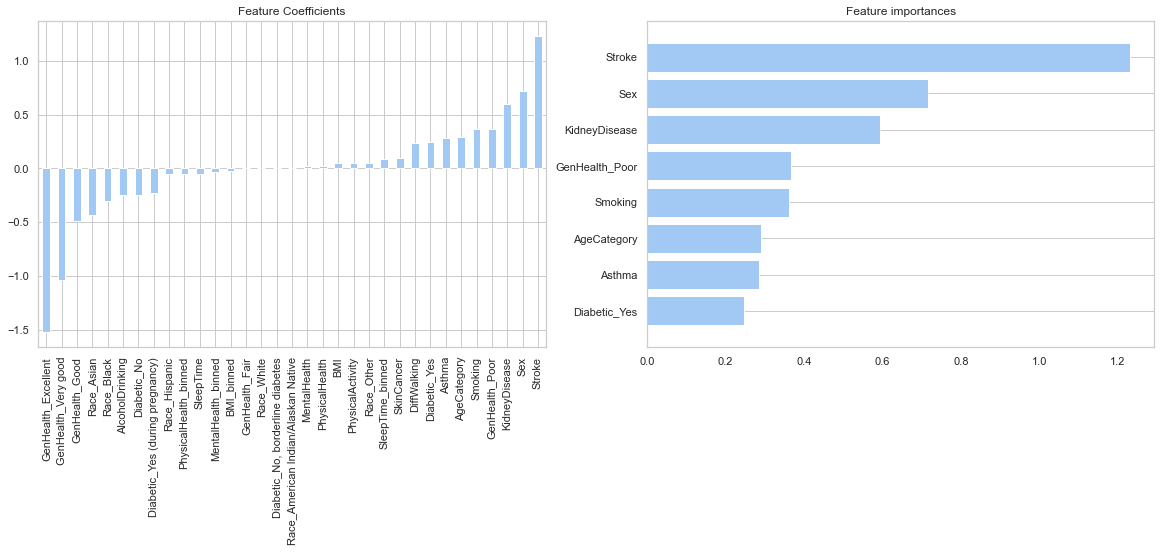

In [43]:
# plot feature coefficients representing feature importance
feature_names = list(lr2.feature_names_in_)
coef_ = np.ndarray.flatten(lr2.coef_)
coef = pd.Series(coef_, feature_names)
fig, ax = plt.subplots(1,2,figsize=(20,6))
coef.sort_values().plot(kind='bar', title='Feature Coefficients', ax=ax[0])
plot.feature_importances(coef_, top_n=8, feature_names=feature_names, ax=ax[1])
plt.show()

In [44]:
# features with negative coef have negative influence on model
print(f'Negative influence on LogReg2 model: \n\n{coef[coef < 0].sort_values()}')

Negative influence on LogReg2 model: 

GenHealth_Excellent               -1.526377
GenHealth_Very good               -1.043515
GenHealth_Good                    -0.490550
Race_Asian                        -0.437705
Race_Black                        -0.303678
AlcoholDrinking                   -0.252500
Diabetic_No                       -0.247494
Diabetic_Yes (during pregnancy)   -0.231706
Race_Hispanic                     -0.052314
PhysicalHealth_binned             -0.050750
SleepTime                         -0.050515
MentalHealth_binned               -0.038386
BMI_binned                        -0.023778
dtype: float64


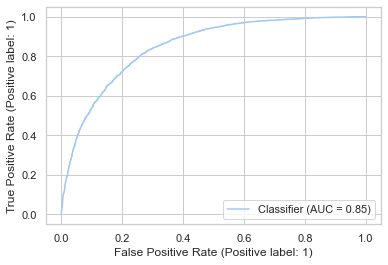

lr2 roc_auc_score: 0.8489586039709504


In [45]:
# LogReg RocCurveDisplays and roc_auc_score

y_pred_prob = lr.predict_proba(X_test)
y_pred_proba = [j for [i,j] in y_pred_prob]
lr_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.show()

ras = roc_auc_score(y_test, y_pred_proba)
print(f'lr2 roc_auc_score: {ras}')

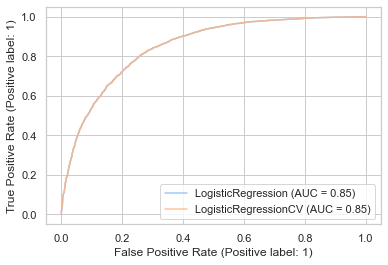

In [46]:
# estimator ROC display
lr_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
ax = plt.gca()
lr2_roc_est = RocCurveDisplay.from_estimator(lr2, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

The difference between the three logistic logression models is minimal.

Summary: label encoding 'AgeCategory' and 'GenHealth' produced more accurate LogReg models than when those two columns were OneHot encoded. The 'liblinear' solver made the model have a higher accuracy score than 'lbfgs' or 'saga' or 'newton-cg' for 'l1' and 'l2'. There is only one solver option for 'elasticnet' penalty. Model precision was not altered for 'l1' or 'l2' based on solver. 
lr2 'liblinear' most accurate so far

lr2 above appears to be the best model with highest accuracy score. all logreg models are close to each other 

**Using only features selected by RidgeCV led to slightly lower accuracy in logistic regression models. Will it improve other models performance?**

**KNN**

In [47]:
# randomizedsearch for knn params
grid_params = {'n_neighbors' : list(range(3,30)),
               'leaf_size' : list(range(1,50,2)),
               'p' : [1,2],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

rs = RandomizedSearchCV(KNeighborsClassifier(), grid_params, verbose=2, cv=5, n_jobs=-1, random_state=42)
rs_knn = rs.fit(X_train, y_train)

print(f'Best params: {rs_knn.best_params_}')
print(f'Best score: {rs_knn.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'weights': 'uniform', 'p': 1, 'n_neighbors': 29, 'metric': 'euclidean', 'leaf_size': 5}
Best score: 0.7469849520003455


In [48]:
# KNN model with GridSearchCV params
knn = KNeighborsClassifier(weights='uniform', p = 1, n_neighbors = 29, metric = 'euclidean', leaf_size = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print('K Neighbors model \n')
print(f'Confusion matrix: \n{cm_knn}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_knn, digits=5)}')

K Neighbors model 

Confusion matrix: 
[[4001 1582]
 [1113 4254]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78236   0.71664   0.74806      5583
           1    0.72892   0.79262   0.75944      5367

    accuracy                        0.75388     10950
   macro avg    0.75564   0.75463   0.75375     10950
weighted avg    0.75617   0.75388   0.75364     10950



In [49]:
# model evaluation against test set
y_hat = knn.predict(X_train)
print(f'KNN training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'KNN test set accuracy: {accuracy_score(y_test, y_pred_knn)}')

KNN training set accuracy: 0.7631494474251387
KNN test set accuracy: 0.7538812785388128


**Decision Tree**

In [50]:
# Grid search for best DecisionTreeClassifier parameters
grid_params = {'criterion' : ['gini', 'entropy'],
               'splitter' : ['best', 'random'],
               'max_depth': list(range(3, 20))}

gs = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose=1, cv=5, n_jobs=-1)
gs_tree = gs.fit(X_train, y_train)

print(f'Best params: {gs_tree.best_params_}')
print(f'Best score: {gs_tree.best_score_}')

Fitting 5 folds for each of 68 candidates, totalling 340 fits
Best params: {'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}
Best score: 0.7556748674581477


In [51]:
# DecisionTreeClassifier using best GridSearchCV parameters
tree = DecisionTreeClassifier(criterion ='entropy', splitter='best', max_depth = 8, random_state = 123)
tree.fit(X_train, y_train)
y_pred_t = tree.predict(X_test)

# evaluate decision tree
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_t)
cm_t = confusion_matrix(y_test, y_pred_t)
print('Decision Tree - Entropy')
print(f'Confusion matrix: \n{cm_t}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_t, digits=5)}')
                                
# model evaluation against test set
y_hat = tree.predict(X_train)
print(f'Decision Tree training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'Decision Tree test set accuracy: {accuracy_score(y_test, y_pred_t)}')

Decision Tree - Entropy
Confusion matrix: 
[[3930 1653]
 [ 991 4376]]

Classification report: 
              precision    recall  f1-score   support

           0    0.79862   0.70392   0.74829      5583
           1    0.72583   0.81535   0.76799      5367

    accuracy                        0.75854     10950
   macro avg    0.76222   0.75964   0.75814     10950
weighted avg    0.76294   0.75854   0.75794     10950

Decision Tree training set accuracy: 0.7651671481634338
Decision Tree test set accuracy: 0.7585388127853882


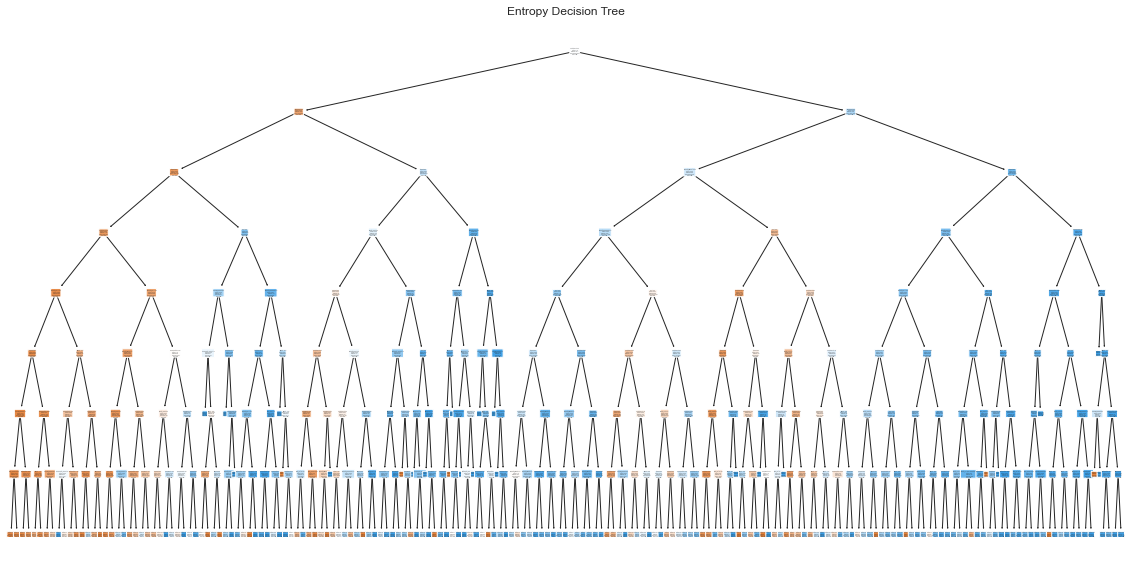

In [52]:
# plot decision tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, rounded=True, feature_names=X_train.columns, class_names=['NO', 'YES']) 
plt.title('Entropy Decision Tree')
plt.show()

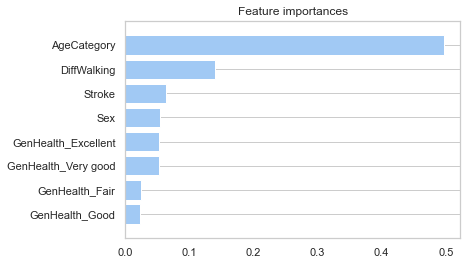

feature_name,importance
AgeCategory,0.497448
DiffWalking,0.139626
Stroke,0.063247
Sex,0.0547413
GenHealth_Excellent,0.0521582
GenHealth_Very good,0.0521402
GenHealth_Fair,0.0244342
GenHealth_Good,0.0231045
GenHealth_Poor,0.0220701
BMI,0.0126467


In [53]:
# plot DecisionTreeClassifier feature importances
feature_names = list(tree.feature_names_in_)
feature_importances = tree.feature_importances_
plot.feature_importances(feature_importances, top_n=8, feature_names=feature_names)
plt.show()

table.feature_importances(feature_importances, feature_names=feature_names)

**Random Forest**

In [ ]:
grid_params = {'criterion' : ['gini', 'entropy'],
               'n_estimators' : list(range(1,500)),
               'max_depth': list(range(3, 20))}

rf_rs = RandomizedSearchCV(RandomForestClassifier(), grid_params, verbose=1, cv=5, n_jobs=-1)
rf = rf_rs.fit(X_train, y_train)

print(f'Best params: {rf.best_params_}')
print(f'Best score: {rf.best_score_}')

Best params: {'n_estimators': 182, 'max_depth': 12, 'criterion': 'entropy'}


Best score: 0.7678538812785388

In [55]:
# entropy Random Forest Classifier model, consider playing with max_depth. is that a hyperparameter?

rfc = RandomForestClassifier(criterion='entropy', n_estimators=182, max_depth=12)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print('Random Forest Entropy model \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_rfc)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfc, digits=5)}')

Random Forest Entropy model 

Confusion matrix: 
 [[4010 1573]
 [ 969 4398]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80538   0.71825   0.75933      5583
           1    0.73656   0.81945   0.77580      5367

    accuracy                        0.76785     10950
   macro avg    0.77097   0.76885   0.76756     10950
weighted avg    0.77165   0.76785   0.76740     10950



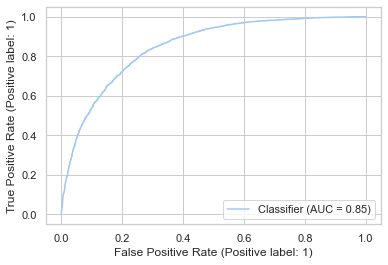

rfc roc_auc_score: 0.8489586039709504


In [56]:
y_pred_rfc_prob = rfc.predict_proba(X_test)
y_pred_proba = [j for [i,j] in y_pred_prob]
rfc_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.show()

ras = roc_auc_score(y_test, y_pred_proba)
print(f'rfc roc_auc_score: {ras}')

In [57]:
# model evaluation against test set
y_hat = rfc.predict(X_train)
print(f'Random Forest training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'Random Forest test set accuracy: {accuracy_score(y_test, y_pred_rfc)}')

Random Forest training set accuracy: 0.7934837437520063
Random Forest test set accuracy: 0.7678538812785388


**XGB**

In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, random_state=123)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# evaluate xgb model
print('XGBoost model: \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_xgb)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgb, digits=5)}')

[20:55:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/cloned/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoost model: 

Confusion matrix: 
 [[4012 1571]
 [1045 4322]]

Classification report: 
              precision    recall  f1-score   support

           0    0.79336   0.71861   0.75414      5583
           1    0.73341   0.80529   0.76767      5367

    accuracy                        0.76110     10950
   macro avg    0.76338   0.76195   0.76090     10950
weighted avg    0.76398   0.76110   0.76077     10950



In [61]:
# XGB model evaluation against test set
y_hat = xgb.predict(X_train)
print(f'XGB training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'XGB test set accuracy: {accuracy_score(y_test, y_pred_xgb)}')

XGB training set accuracy: 0.8046040262301096
XGB test set accuracy: 0.7610958904109589


## Conclusion

Though linear models have lower complexity in comparison to different types of black box models, that does not mean they produce the lowest accuracy scores from the same data. 

After trying a few different types of models and utilizing both GridSearchCV and RandomizedSearchCV for hyperparameter optimization, logistic regression model with L1 penalty is the most accurate model. 